# 定义神经网络

In [25]:
import numpy as np

In [26]:
class Node:
    def __init__(self,inputs=[]):
        self.inputs = inputs
        self.outputs = []
        
        for n in self.inputs:
            n.outputs.append(self)
            
        self.value = None
        self.gradients = {}
        
    def forward(self):
        raise NotImplemented
        
    def backforward(self):
        raise NotImplemented

In [56]:
#输入节点，包括神经网络输入节点，权重节点和偏差节点
class Input(Node):
    def __init__(self):
        Node.__init__(self)
    def forward(self,value=None):
        #定义节点数值
        if value is not None:
            self.value = value
    def backward(self):
        self.gradients = {self:0} #初始化
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self] = grad_cost*1
        

In [28]:
class Add(Node):
    def __init__(self,*nodes):
        Node.__init__(self,nodes)
    def forward(self):
        self.value = sum(map(lambda n:n.value,self.inputs))

map(function, iterable, ...)<br>
Python 3.x 返回迭代器。<br>

In [54]:
class Linear(Node):
    #全连接网络层的计算
    def __init__(self,nodes,weights,bias):
        Node.__init__(self,[nodes,weights,bias])
    def forward(self):
        inputs = self.inputs[0].value
        weights = self.inputs[1].value
        bias = self.inputs[2].value
        self.value = np.dot(inputs,weights)+bias #wx+b
    def backward(self):
        #初始化
        self.gradients = {n:np.zeros_like(n.value) for n in self.inputs}
        
        for n in self.outputs:
            grad_cost = n.gradients[self]
            #分别对inputs,weights,bias的梯度
            self.gradients[self.inputs[0]] = np.dot(grad_cost,self.inputs[1].value.T)
            self.gradients[self.inputs[1]] = np.dot(self.inputs[0].value.T,grad_cost)
            self.gradients[self.inputs[2]] = np.sum(grad_cost,axis=0,keepdims=False)

In [30]:
class Sigmoid(Node):
    #定义sigmoid函数
    def __init__(self,node):
        Node.__init__(self,[node])
    def _sigmoid(self,x):
        return 1./(1+np.exp(-1*x))
    def forward(self):
        self.x = self.inputs[0].value
        self.value = self._sigmoid(self.x)
    def backward(self):
        self.partial = self._sigmoid(self.x)*(1-self._sigmoid(self.x))
        self.gradients = {n:np.zeros_like(n.value) for n in self.inputs}
        for n in self.outputs:
            grad_cost = n.gradients[self]
            self.gradients[self.inputs[0]] = grad_cost*self.partial

In [31]:
class MSE(Node):
    #定义平均平方误差
    def __init__(self,y,a):
        Node.__init__(self,[y,a])
    def forward(self):
        #前向传播计算
        y = self.inputs[0].value.reshape(-1,1)
        a = self.inputs[1].value.reshape(-1,1)
        assert(y.shape == a.shape)
        self.m = self.inputs[0].value.shape[0]
        self.diff = y-a
        self.value = np.mean(self.diff**2)
    def backward(self):
        self.gradients[self.inputs[0]] = (2/self.m)*self.diff
        self.gradients[self.inputs[1]] = (-2/self.m)*self.diff

**assert:**用于判断一个表达式，在表达式条件为 false 的时候触发异常。

In [32]:
def forward_and_backward(outputnode,graph):
    for n in graph:
        n.forward()
    for n in graph[::-1]:
        n.backward()

Python中[-1],[:-1],[::-1],[2::-1]的区别：<br>
e.g.[1,2,3,4,5]
[-1]:取最后一个元素[5]<br>
[:-1]:除了最后一个全取[1,2,3,4]<br>
[::-1]:从最后一个开始依次取全部元素[5,4,3,2,1]<br>
[2::-1]:从下标为2的元素翻转读取[3,2,1]<br>

In [50]:
def topological_sort(feed_dict):
    #feed_dict:键为输入节点，值为对应的值
    input_nodes = [n for n in feed_dict.keys()]
    G={}
    nodes = [n for n in input_nodes]
    while len(nodes)>0:
        n = nodes.pop(0)
        if n not in G:
            G[n] = {'in':set(),'out':set()}
        for m in n.outputs:
            if m not in G:
                G[m] ={'in':set(),'out':set()}
            G[n]['out'].add(m)
            G[m]['in'].add(n)
            nodes.append(m)
    L = []
    S = set(input_nodes)
    while len(S)>0:
        n = S.pop()
        if isinstance(n,Input):
            n.value = feed_dict[n]
        L.append(n)
        for m in n.outputs:
            G[n]['out'].remove(m)
            G[m]['in'].remove(n)
            if len(G[m]['in'])==0:
                S.add(m)
    return L

In [34]:
def sgd_update(trainables,learning_rate=1e-2):
    for t in trainables:
        t.value += -1*learning_rate * t.gradients[t]

# 例子：波士顿房价

In [35]:
from sklearn.datasets import load_boston

In [36]:
data = load_boston()

In [37]:
losses = []

In [38]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.utils import shuffle,resample

**Load data:**

In [39]:
data = load_boston()
X_ = data['data']
y_ = data['target']

**Normalization:**

$$y = \frac{x-\mu}{\sigma}$$

In [40]:
X_ = (X_ - np.mean(X_,axis=0))/np.std(X_,axis=0)

In [43]:
n_features = X_.shape[1]
n_hidden = 10
W1_ = np.random.randn(n_features,n_hidden)
b1_ = np.zeros(n_hidden)
W2_ = np.random.randn(n_hidden,1) 
b2_ = np.zeros(1)

**Neural network:**

In [57]:
X,y = Input(),Input()
W1,b1 = Input(),Input()
W2,b2 = Input(),Input()

l1 = Linear(X,W1,b1)
s1 = Sigmoid(l1)
l2 = Linear(s1,W2,b2)
cost = MSE(y,l2)

feed_dict = {
    X:X_,
    y:y_,
    W1:W1_,
    b1:b1_,
    W2:W2_,
    b2:b2_
}
epochs = 5000
m = X_.shape[0] #总样本数
batch_size = 16
iterations = m // batch_size 

graph = topological_sort(feed_dict)
trainables = [W1,b1,W2,b2]
print("Total number of examples = {}".format(m))

for i in range(epochs):
    loss = 0
    for j in range(iterations):
        #随机采样数据
        X_batch,y_batch = resample(X_,y_,n_samples=batch_size)
        #重置X和y Inputs
        X.value = X_batch
        y.value = y_batch
        #计算forward_backward
        _=None
        forward_and_backward(_,graph)
        #sgd更新
        rate = 1e-2
        sgd_update(trainables,rate)
        loss += graph[-1].value
    #打印
    if i%100==0:
        print("Epoch:{},Loss:{:.3f}".format(i+1,loss/iterations))
        losses.append(loss)

Total number of examples = 506
Epoch:1,Loss:214.477
Epoch:101,Loss:8.668
Epoch:201,Loss:4.099
Epoch:301,Loss:4.890
Epoch:401,Loss:4.150
Epoch:501,Loss:3.464
Epoch:601,Loss:3.226
Epoch:701,Loss:3.215
Epoch:801,Loss:3.568
Epoch:901,Loss:3.546
Epoch:1001,Loss:3.724
Epoch:1101,Loss:3.130
Epoch:1201,Loss:3.769
Epoch:1301,Loss:3.279
Epoch:1401,Loss:3.346
Epoch:1501,Loss:2.438
Epoch:1601,Loss:2.748
Epoch:1701,Loss:3.078
Epoch:1801,Loss:2.892
Epoch:1901,Loss:2.758
Epoch:2001,Loss:2.980
Epoch:2101,Loss:2.566
Epoch:2201,Loss:2.880
Epoch:2301,Loss:2.992
Epoch:2401,Loss:2.960
Epoch:2501,Loss:2.471
Epoch:2601,Loss:2.663
Epoch:2701,Loss:3.113
Epoch:2801,Loss:2.815
Epoch:2901,Loss:3.364
Epoch:3001,Loss:2.684
Epoch:3101,Loss:2.291
Epoch:3201,Loss:2.938
Epoch:3301,Loss:2.758
Epoch:3401,Loss:3.438
Epoch:3501,Loss:2.446
Epoch:3601,Loss:2.719
Epoch:3701,Loss:2.920
Epoch:3801,Loss:3.091
Epoch:3901,Loss:3.095
Epoch:4001,Loss:3.034
Epoch:4101,Loss:2.725
Epoch:4201,Loss:2.942
Epoch:4301,Loss:2.953
Epoch:4401,

In [58]:
def forward(outputNode,graph):
    for n in graph:
        n.forward()
    return outputNode.value

In [60]:
forward(l2,graph)

array([[13.96388608],
       [24.43783243],
       [25.3063237 ],
       [30.13043647],
       [21.17220159],
       [13.96388608],
       [15.66192727],
       [21.20420741],
       [24.44308441],
       [29.42172629],
       [15.14830513],
       [23.90463272],
       [21.99842517],
       [17.15016181],
       [15.58805612],
       [ 9.52043014]])

**画图:loss**

In [61]:
import matplotlib.pyplot as plt

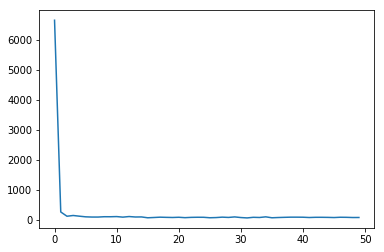

In [62]:
plt.plot(range(len(losses)),losses)

In [63]:
W2.value

array([[ 6.9508871 ],
       [ 5.39133843],
       [17.20664488],
       [ 8.37261895],
       [20.01601353],
       [ 4.51017992],
       [-4.65475983],
       [ 4.82081562],
       [ 6.06950035],
       [ 6.37344266]])

In [64]:
X_ = data['data']

In [65]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

**用keras搭建网络：**

In [66]:
import keras

Using TensorFlow backend.
d:\program files\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\program files\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\program files\python\python36\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\program files\python\python36\lib\site-packages\tenso

In [67]:
X_[0]

array([6.320e-03, 1.800e+01, 2.310e+00, 0.000e+00, 5.380e-01, 6.575e+00,
       6.520e+01, 4.090e+00, 1.000e+00, 2.960e+02, 1.530e+01, 3.969e+02,
       4.980e+00])

In [69]:
from keras.layers import Dense
from keras.models import Sequential
model = Sequential()
model.add(Dense(units=64,activation='sigmoid',input_dim=13))
model.add(Dense(units=30,activation='sigmoid',input_dim=64))
model.add(Dense(units=1))
model.compile(loss='mse',optimizer='sgd',metrics=['mse'])

Instructions for updating:
Colocations handled automatically by placer.


In [70]:
model.fit(X_,y_,epochs=5000,batch_size=32)

Instructions for updating:
Use tf.cast instead.
Epoch 1/5000
506/506 [==============================] - 0s 447us/step - loss: 144.6335 - mean_squared_error: 144.6335
Epoch 2/5000
506/506 [==============================] - 0s 47us/step - loss: 80.8154 - mean_squared_error: 80.8154
Epoch 3/5000
506/506 [==============================] - 0s 40us/step - loss: 81.6417 - mean_squared_error: 81.6417
Epoch 4/5000
506/506 [==============================] - 0s 40us/step - loss: 81.0052 - mean_squared_error: 81.0052
Epoch 5/5000
506/506 [==============================] - 0s 47us/step - loss: 80.8064 - mean_squared_error: 80.8064
Epoch 6/5000
506/506 [==============================] - 0s 47us/step - loss: 83.3135 - mean_squared_error: 83.3135
Epoch 7/5000
506/506 [==============================] - 0s 40us/step - loss: 84.2780 - mean_squared_error: 84.2780
Epoch 8/5000
506/506 [==============================] - 0s 73us/step - loss: 83.1568 - mean_squared_error: 83.1568
Epoch 9/5000
506/506 [=======

506/506 [==============================] - 0s 47us/step - loss: 85.8035 - mean_squared_error: 85.8035
Epoch 139/5000
506/506 [==============================] - 0s 55us/step - loss: 84.7711 - mean_squared_error: 84.7711
Epoch 140/5000
506/506 [==============================] - 0s 47us/step - loss: 84.9887 - mean_squared_error: 84.9887
Epoch 141/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9321 - mean_squared_error: 84.9321
Epoch 142/5000
506/506 [==============================] - 0s 32us/step - loss: 86.4386 - mean_squared_error: 86.4386
Epoch 143/5000
506/506 [==============================] - 0s 32us/step - loss: 85.6351 - mean_squared_error: 85.6351
Epoch 144/5000
506/506 [==============================] - 0s 24us/step - loss: 85.3616 - mean_squared_error: 85.3616
Epoch 145/5000
506/506 [==============================] - 0s 24us/step - loss: 87.0354 - mean_squared_error: 87.0354
Epoch 146/5000
506/506 [==============================] - 0s 32us/step - loss: 

506/506 [==============================] - 0s 40us/step - loss: 85.5985 - mean_squared_error: 85.5985
Epoch 279/5000
506/506 [==============================] - 0s 32us/step - loss: 85.3946 - mean_squared_error: 85.3946
Epoch 280/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9010 - mean_squared_error: 84.9010
Epoch 281/5000
506/506 [==============================] - 0s 32us/step - loss: 85.5486 - mean_squared_error: 85.5486
Epoch 282/5000
506/506 [==============================] - 0s 40us/step - loss: 85.8105 - mean_squared_error: 85.8105
Epoch 283/5000
506/506 [==============================] - 0s 47us/step - loss: 85.8498 - mean_squared_error: 85.8498
Epoch 284/5000
506/506 [==============================] - 0s 40us/step - loss: 84.7994 - mean_squared_error: 84.7994
Epoch 285/5000
506/506 [==============================] - 0s 47us/step - loss: 85.5863 - mean_squared_error: 85.5863
Epoch 286/5000
506/506 [==============================] - 0s 40us/step - loss: 

506/506 [==============================] - 0s 32us/step - loss: 84.8259 - mean_squared_error: 84.8259
Epoch 419/5000
506/506 [==============================] - 0s 32us/step - loss: 86.0599 - mean_squared_error: 86.0599
Epoch 420/5000
506/506 [==============================] - 0s 32us/step - loss: 84.5085 - mean_squared_error: 84.5085
Epoch 421/5000
506/506 [==============================] - 0s 32us/step - loss: 85.5223 - mean_squared_error: 85.5223
Epoch 422/5000
506/506 [==============================] - 0s 32us/step - loss: 86.1693 - mean_squared_error: 86.1693
Epoch 423/5000
506/506 [==============================] - 0s 32us/step - loss: 85.5626 - mean_squared_error: 85.5626
Epoch 424/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8094 - mean_squared_error: 84.8094
Epoch 425/5000
506/506 [==============================] - 0s 40us/step - loss: 85.5573 - mean_squared_error: 85.5573
Epoch 426/5000
506/506 [==============================] - 0s 40us/step - loss: 

506/506 [==============================] - 0s 40us/step - loss: 86.9333 - mean_squared_error: 86.9333
Epoch 558/5000
506/506 [==============================] - 0s 32us/step - loss: 86.6574 - mean_squared_error: 86.6574
Epoch 559/5000
506/506 [==============================] - 0s 32us/step - loss: 84.7496 - mean_squared_error: 84.7496
Epoch 560/5000
506/506 [==============================] - 0s 40us/step - loss: 85.6996 - mean_squared_error: 85.6996
Epoch 561/5000
506/506 [==============================] - 0s 32us/step - loss: 86.3134 - mean_squared_error: 86.3134
Epoch 562/5000
506/506 [==============================] - 0s 32us/step - loss: 85.8985 - mean_squared_error: 85.8985
Epoch 563/5000
506/506 [==============================] - 0s 32us/step - loss: 85.6304 - mean_squared_error: 85.6304
Epoch 564/5000
506/506 [==============================] - 0s 32us/step - loss: 85.6298 - mean_squared_error: 85.6298
Epoch 565/5000
506/506 [==============================] - 0s 32us/step - loss: 

506/506 [==============================] - 0s 32us/step - loss: 85.5301 - mean_squared_error: 85.5301
Epoch 696/5000
506/506 [==============================] - 0s 40us/step - loss: 85.2640 - mean_squared_error: 85.2640
Epoch 697/5000
506/506 [==============================] - 0s 32us/step - loss: 85.1341 - mean_squared_error: 85.1341
Epoch 698/5000
506/506 [==============================] - 0s 32us/step - loss: 85.9128 - mean_squared_error: 85.9128
Epoch 699/5000
506/506 [==============================] - 0s 32us/step - loss: 85.2763 - mean_squared_error: 85.2763
Epoch 700/5000
506/506 [==============================] - 0s 32us/step - loss: 85.3638 - mean_squared_error: 85.3638
Epoch 701/5000
506/506 [==============================] - 0s 32us/step - loss: 85.4125 - mean_squared_error: 85.4125
Epoch 702/5000
506/506 [==============================] - 0s 40us/step - loss: 85.7812 - mean_squared_error: 85.7812
Epoch 703/5000
506/506 [==============================] - 0s 40us/step - loss: 

506/506 [==============================] - 0s 40us/step - loss: 86.5758 - mean_squared_error: 86.5758
Epoch 835/5000
506/506 [==============================] - 0s 55us/step - loss: 86.9215 - mean_squared_error: 86.9215
Epoch 836/5000
506/506 [==============================] - 0s 32us/step - loss: 85.5482 - mean_squared_error: 85.5482
Epoch 837/5000
506/506 [==============================] - 0s 37us/step - loss: 86.2446 - mean_squared_error: 86.2446
Epoch 838/5000
506/506 [==============================] - 0s 101us/step - loss: 85.5490 - mean_squared_error: 85.5490
Epoch 839/5000
506/506 [==============================] - 0s 89us/step - loss: 86.5178 - mean_squared_error: 86.5178
Epoch 840/5000
506/506 [==============================] - 0s 52us/step - loss: 86.4246 - mean_squared_error: 86.4246
Epoch 841/5000
506/506 [==============================] - 0s 85us/step - loss: 84.9886 - mean_squared_error: 84.9886
Epoch 842/5000
506/506 [==============================] - 0s 80us/step - loss:

506/506 [==============================] - 0s 47us/step - loss: 86.1387 - mean_squared_error: 86.1387
Epoch 973/5000
506/506 [==============================] - 0s 47us/step - loss: 85.6062 - mean_squared_error: 85.6062
Epoch 974/5000
506/506 [==============================] - 0s 40us/step - loss: 85.5921 - mean_squared_error: 85.5921
Epoch 975/5000
506/506 [==============================] - 0s 42us/step - loss: 85.3638 - mean_squared_error: 85.3638
Epoch 976/5000
506/506 [==============================] - 0s 74us/step - loss: 84.8507 - mean_squared_error: 84.8507
Epoch 977/5000
506/506 [==============================] - 0s 57us/step - loss: 86.2657 - mean_squared_error: 86.2657
Epoch 978/5000
506/506 [==============================] - 0s 48us/step - loss: 86.8857 - mean_squared_error: 86.8857
Epoch 979/5000
506/506 [==============================] - 0s 44us/step - loss: 85.1708 - mean_squared_error: 85.1708
Epoch 980/5000
506/506 [==============================] - 0s 60us/step - loss: 

506/506 [==============================] - 0s 46us/step - loss: 86.5785 - mean_squared_error: 86.5785
Epoch 1111/5000
506/506 [==============================] - 0s 32us/step - loss: 86.0336 - mean_squared_error: 86.0336
Epoch 1112/5000
506/506 [==============================] - 0s 38us/step - loss: 85.9403 - mean_squared_error: 85.9403
Epoch 1113/5000
506/506 [==============================] - ETA: 0s - loss: 99.3167 - mean_squared_error: 99.31 - 0s 32us/step - loss: 85.7969 - mean_squared_error: 85.7969
Epoch 1114/5000
506/506 [==============================] - 0s 22us/step - loss: 85.5950 - mean_squared_error: 85.5950
Epoch 1115/5000
506/506 [==============================] - 0s 62us/step - loss: 85.8284 - mean_squared_error: 85.8284
Epoch 1116/5000
506/506 [==============================] - 0s 36us/step - loss: 86.2041 - mean_squared_error: 86.2041
Epoch 1117/5000
506/506 [==============================] - 0s 91us/step - loss: 85.3366 - mean_squared_error: 85.3366
Epoch 1118/5000
50

506/506 [==============================] - 0s 47us/step - loss: 86.3762 - mean_squared_error: 86.3762
Epoch 1180/5000
506/506 [==============================] - 0s 32us/step - loss: 86.0256 - mean_squared_error: 86.0256
Epoch 1181/5000
506/506 [==============================] - 0s 40us/step - loss: 87.0305 - mean_squared_error: 87.0305
Epoch 1182/5000
506/506 [==============================] - 0s 40us/step - loss: 86.3977 - mean_squared_error: 86.3977
Epoch 1183/5000
506/506 [==============================] - 0s 35us/step - loss: 86.6612 - mean_squared_error: 86.6612
Epoch 1184/5000
506/506 [==============================] - 0s 40us/step - loss: 87.1279 - mean_squared_error: 87.1279
Epoch 1185/5000
506/506 [==============================] - 0s 57us/step - loss: 84.8299 - mean_squared_error: 84.8299
Epoch 1186/5000
506/506 [==============================] - 0s 64us/step - loss: 85.0748 - mean_squared_error: 85.0748
Epoch 1187/5000
506/506 [==============================] - 0s 54us/step 

506/506 [==============================] - 0s 38us/step - loss: 85.6541 - mean_squared_error: 85.6541
Epoch 1318/5000
506/506 [==============================] - 0s 32us/step - loss: 86.4460 - mean_squared_error: 86.4460
Epoch 1319/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0004 - mean_squared_error: 85.0004
Epoch 1320/5000
506/506 [==============================] - 0s 35us/step - loss: 85.9275 - mean_squared_error: 85.9275
Epoch 1321/5000
506/506 [==============================] - 0s 30us/step - loss: 85.1782 - mean_squared_error: 85.1782
Epoch 1322/5000
506/506 [==============================] - 0s 50us/step - loss: 86.6800 - mean_squared_error: 86.6800
Epoch 1323/5000
506/506 [==============================] - 0s 50us/step - loss: 85.6733 - mean_squared_error: 85.6733
Epoch 1324/5000
506/506 [==============================] - 0s 53us/step - loss: 85.6339 - mean_squared_error: 85.6339
Epoch 1325/5000
506/506 [==============================] - 0s 31us/step 

506/506 [==============================] - 0s 38us/step - loss: 85.5465 - mean_squared_error: 85.5465
Epoch 1456/5000
506/506 [==============================] - 0s 32us/step - loss: 86.5382 - mean_squared_error: 86.5382
Epoch 1457/5000
506/506 [==============================] - 0s 36us/step - loss: 85.6675 - mean_squared_error: 85.6675
Epoch 1458/5000
506/506 [==============================] - 0s 42us/step - loss: 85.8485 - mean_squared_error: 85.8485
Epoch 1459/5000
506/506 [==============================] - 0s 40us/step - loss: 87.2064 - mean_squared_error: 87.2064
Epoch 1460/5000
506/506 [==============================] - 0s 28us/step - loss: 85.7619 - mean_squared_error: 85.7619
Epoch 1461/5000
506/506 [==============================] - 0s 60us/step - loss: 85.2099 - mean_squared_error: 85.2099
Epoch 1462/5000
506/506 [==============================] - 0s 35us/step - loss: 85.4056 - mean_squared_error: 85.4056
Epoch 1463/5000
506/506 [==============================] - 0s 47us/step 

506/506 [==============================] - 0s 45us/step - loss: 85.4491 - mean_squared_error: 85.4491
Epoch 1525/5000
506/506 [==============================] - 0s 40us/step - loss: 85.8162 - mean_squared_error: 85.8162
Epoch 1526/5000
506/506 [==============================] - 0s 39us/step - loss: 85.8634 - mean_squared_error: 85.8634
Epoch 1527/5000
506/506 [==============================] - 0s 32us/step - loss: 83.9245 - mean_squared_error: 83.9245
Epoch 1528/5000
506/506 [==============================] - 0s 57us/step - loss: 84.7794 - mean_squared_error: 84.7794
Epoch 1529/5000
506/506 [==============================] - 0s 40us/step - loss: 85.5684 - mean_squared_error: 85.5684
Epoch 1530/5000
506/506 [==============================] - 0s 47us/step - loss: 85.6635 - mean_squared_error: 85.6635
Epoch 1531/5000
506/506 [==============================] - 0s 43us/step - loss: 85.0864 - mean_squared_error: 85.0864
Epoch 1532/5000
506/506 [==============================] - 0s 44us/step 

506/506 [==============================] - 0s 40us/step - loss: 85.4967 - mean_squared_error: 85.4967
Epoch 1594/5000
506/506 [==============================] - 0s 32us/step - loss: 86.6036 - mean_squared_error: 86.6036
Epoch 1595/5000
506/506 [==============================] - 0s 40us/step - loss: 85.8585 - mean_squared_error: 85.8585
Epoch 1596/5000
506/506 [==============================] - 0s 40us/step - loss: 86.0871 - mean_squared_error: 86.0871
Epoch 1597/5000
506/506 [==============================] - 0s 43us/step - loss: 86.3196 - mean_squared_error: 86.3196
Epoch 1598/5000
506/506 [==============================] - 0s 66us/step - loss: 86.1165 - mean_squared_error: 86.1165
Epoch 1599/5000
506/506 [==============================] - 0s 48us/step - loss: 86.2770 - mean_squared_error: 86.2770
Epoch 1600/5000
506/506 [==============================] - 0s 40us/step - loss: 85.3588 - mean_squared_error: 85.3588
Epoch 1601/5000
506/506 [==============================] - 0s 49us/step 

506/506 [==============================] - 0s 40us/step - loss: 84.7933 - mean_squared_error: 84.7933
Epoch 1731/5000
506/506 [==============================] - 0s 32us/step - loss: 86.6766 - mean_squared_error: 86.6766
Epoch 1732/5000
506/506 [==============================] - 0s 40us/step - loss: 85.2100 - mean_squared_error: 85.2100
Epoch 1733/5000
506/506 [==============================] - 0s 38us/step - loss: 86.1269 - mean_squared_error: 86.1269
Epoch 1734/5000
506/506 [==============================] - 0s 59us/step - loss: 85.5992 - mean_squared_error: 85.5992
Epoch 1735/5000
506/506 [==============================] - 0s 27us/step - loss: 86.3786 - mean_squared_error: 86.3786
Epoch 1736/5000
506/506 [==============================] - 0s 71us/step - loss: 84.9291 - mean_squared_error: 84.9291
Epoch 1737/5000
506/506 [==============================] - 0s 44us/step - loss: 85.7404 - mean_squared_error: 85.7404
Epoch 1738/5000
506/506 [==============================] - 0s 54us/step 

506/506 [==============================] - 0s 42us/step - loss: 85.9809 - mean_squared_error: 85.9809
Epoch 1869/5000
506/506 [==============================] - 0s 32us/step - loss: 86.0607 - mean_squared_error: 86.0607
Epoch 1870/5000
506/506 [==============================] - 0s 40us/step - loss: 85.5733 - mean_squared_error: 85.5733
Epoch 1871/5000
506/506 [==============================] - 0s 36us/step - loss: 85.5179 - mean_squared_error: 85.5179
Epoch 1872/5000
506/506 [==============================] - 0s 39us/step - loss: 85.4135 - mean_squared_error: 85.4135
Epoch 1873/5000
506/506 [==============================] - 0s 33us/step - loss: 86.3214 - mean_squared_error: 86.3214
Epoch 1874/5000
506/506 [==============================] - 0s 74us/step - loss: 87.0818 - mean_squared_error: 87.0818
Epoch 1875/5000
506/506 [==============================] - 0s 63us/step - loss: 85.9410 - mean_squared_error: 85.9410
Epoch 1876/5000
506/506 [==============================] - 0s 47us/step 

506/506 [==============================] - 0s 32us/step - loss: 87.8288 - mean_squared_error: 87.8288
Epoch 2007/5000
506/506 [==============================] - 0s 32us/step - loss: 85.2204 - mean_squared_error: 85.2204
Epoch 2008/5000
506/506 [==============================] - 0s 40us/step - loss: 84.9104 - mean_squared_error: 84.9104
Epoch 2009/5000
506/506 [==============================] - 0s 32us/step - loss: 87.9867 - mean_squared_error: 87.9867
Epoch 2010/5000
506/506 [==============================] - 0s 38us/step - loss: 86.0356 - mean_squared_error: 86.0356
Epoch 2011/5000
506/506 [==============================] - 0s 45us/step - loss: 85.8867 - mean_squared_error: 85.8867
Epoch 2012/5000
506/506 [==============================] - 0s 62us/step - loss: 85.5545 - mean_squared_error: 85.5545
Epoch 2013/5000
506/506 [==============================] - 0s 54us/step - loss: 85.7057 - mean_squared_error: 85.7057
Epoch 2014/5000
506/506 [==============================] - 0s 54us/step 

506/506 [==============================] - 0s 32us/step - loss: 85.6733 - mean_squared_error: 85.6733
Epoch 2076/5000
506/506 [==============================] - 0s 47us/step - loss: 85.8087 - mean_squared_error: 85.8087
Epoch 2077/5000
506/506 [==============================] - 0s 40us/step - loss: 86.0856 - mean_squared_error: 86.0856
Epoch 2078/5000
506/506 [==============================] - 0s 36us/step - loss: 86.4726 - mean_squared_error: 86.4726
Epoch 2079/5000
506/506 [==============================] - 0s 55us/step - loss: 86.3186 - mean_squared_error: 86.3186
Epoch 2080/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9333 - mean_squared_error: 84.9333
Epoch 2081/5000
506/506 [==============================] - 0s 33us/step - loss: 86.0224 - mean_squared_error: 86.0224
Epoch 2082/5000
506/506 [==============================] - 0s 29us/step - loss: 86.1436 - mean_squared_error: 86.1436
Epoch 2083/5000
506/506 [==============================] - 0s 55us/step 

506/506 [==============================] - 0s 31us/step - loss: 86.0181 - mean_squared_error: 86.0181
Epoch 2214/5000
506/506 [==============================] - 0s 32us/step - loss: 86.9451 - mean_squared_error: 86.9451
Epoch 2215/5000
506/506 [==============================] - 0s 31us/step - loss: 85.9899 - mean_squared_error: 85.9899
Epoch 2216/5000
506/506 [==============================] - 0s 21us/step - loss: 86.5345 - mean_squared_error: 86.5345
Epoch 2217/5000
506/506 [==============================] - 0s 53us/step - loss: 86.8778 - mean_squared_error: 86.8778
Epoch 2218/5000
506/506 [==============================] - 0s 46us/step - loss: 85.7568 - mean_squared_error: 85.7568
Epoch 2219/5000
506/506 [==============================] - 0s 49us/step - loss: 85.2739 - mean_squared_error: 85.2739
Epoch 2220/5000
506/506 [==============================] - 0s 45us/step - loss: 85.8417 - mean_squared_error: 85.8417
Epoch 2221/5000
506/506 [==============================] - 0s 48us/step 

506/506 [==============================] - 0s 44us/step - loss: 85.3863 - mean_squared_error: 85.3863
Epoch 2352/5000
506/506 [==============================] - 0s 40us/step - loss: 85.0180 - mean_squared_error: 85.0180
Epoch 2353/5000
506/506 [==============================] - 0s 32us/step - loss: 85.6419 - mean_squared_error: 85.6419
Epoch 2354/5000
506/506 [==============================] - 0s 37us/step - loss: 85.2806 - mean_squared_error: 85.2806
Epoch 2355/5000
506/506 [==============================] - 0s 22us/step - loss: 85.7278 - mean_squared_error: 85.7278
Epoch 2356/5000
506/506 [==============================] - 0s 65us/step - loss: 84.9298 - mean_squared_error: 84.9298
Epoch 2357/5000
506/506 [==============================] - 0s 45us/step - loss: 86.2357 - mean_squared_error: 86.2357
Epoch 2358/5000
506/506 [==============================] - 0s 46us/step - loss: 86.7696 - mean_squared_error: 86.7696
Epoch 2359/5000
506/506 [==============================] - 0s 36us/step 

506/506 [==============================] - 0s 44us/step - loss: 84.3791 - mean_squared_error: 84.3791
Epoch 2421/5000
506/506 [==============================] - 0s 37us/step - loss: 86.8274 - mean_squared_error: 86.8274
Epoch 2422/5000
506/506 [==============================] - 0s 53us/step - loss: 85.7254 - mean_squared_error: 85.7254
Epoch 2423/5000
506/506 [==============================] - 0s 27us/step - loss: 85.4485 - mean_squared_error: 85.4485
Epoch 2424/5000
506/506 [==============================] - 0s 50us/step - loss: 85.2271 - mean_squared_error: 85.2271
Epoch 2425/5000
506/506 [==============================] - 0s 49us/step - loss: 86.9929 - mean_squared_error: 86.9929
Epoch 2426/5000
506/506 [==============================] - 0s 46us/step - loss: 86.8208 - mean_squared_error: 86.8208
Epoch 2427/5000
506/506 [==============================] - 0s 35us/step - loss: 84.5641 - mean_squared_error: 84.5641
Epoch 2428/5000
506/506 [==============================] - 0s 56us/step 

506/506 [==============================] - 0s 47us/step - loss: 86.7266 - mean_squared_error: 86.7266
Epoch 2559/5000
506/506 [==============================] - 0s 32us/step - loss: 86.5461 - mean_squared_error: 86.5461
Epoch 2560/5000
506/506 [==============================] - 0s 47us/step - loss: 84.8463 - mean_squared_error: 84.8463
Epoch 2561/5000
506/506 [==============================] - 0s 32us/step - loss: 85.7355 - mean_squared_error: 85.7355
Epoch 2562/5000
506/506 [==============================] - 0s 32us/step - loss: 85.7168 - mean_squared_error: 85.7168
Epoch 2563/5000
506/506 [==============================] - 0s 37us/step - loss: 85.9961 - mean_squared_error: 85.9961
Epoch 2564/5000
506/506 [==============================] - 0s 43us/step - loss: 86.0950 - mean_squared_error: 86.0950
Epoch 2565/5000
506/506 [==============================] - 0s 43us/step - loss: 86.0373 - mean_squared_error: 86.0373
Epoch 2566/5000
506/506 [==============================] - 0s 53us/step 

506/506 [==============================] - 0s 40us/step - loss: 85.7425 - mean_squared_error: 85.7425
Epoch 2628/5000
506/506 [==============================] - 0s 43us/step - loss: 84.9955 - mean_squared_error: 84.9955
Epoch 2629/5000
506/506 [==============================] - 0s 32us/step - loss: 85.0189 - mean_squared_error: 85.0189
Epoch 2630/5000
506/506 [==============================] - 0s 59us/step - loss: 86.4795 - mean_squared_error: 86.4795
Epoch 2631/5000
506/506 [==============================] - ETA: 0s - loss: 104.7408 - mean_squared_error: 104.74 - 0s 100us/step - loss: 86.2250 - mean_squared_error: 86.2250
Epoch 2632/5000
506/506 [==============================] - 0s 54us/step - loss: 85.3290 - mean_squared_error: 85.3290
Epoch 2633/5000
506/506 [==============================] - 0s 46us/step - loss: 86.1544 - mean_squared_error: 86.1544
Epoch 2634/5000
506/506 [==============================] - 0s 21us/step - loss: 85.8659 - mean_squared_error: 85.8659
Epoch 2635/5000

506/506 [==============================] - 0s 40us/step - loss: 85.3787 - mean_squared_error: 85.3787
Epoch 2765/5000
506/506 [==============================] - 0s 42us/step - loss: 85.0151 - mean_squared_error: 85.0151
Epoch 2766/5000
506/506 [==============================] - 0s 34us/step - loss: 84.9346 - mean_squared_error: 84.9346
Epoch 2767/5000
506/506 [==============================] - 0s 44us/step - loss: 84.7593 - mean_squared_error: 84.7593
Epoch 2768/5000
506/506 [==============================] - 0s 53us/step - loss: 84.9525 - mean_squared_error: 84.9525
Epoch 2769/5000
506/506 [==============================] - 0s 47us/step - loss: 85.0713 - mean_squared_error: 85.0713
Epoch 2770/5000
506/506 [==============================] - 0s 50us/step - loss: 85.2409 - mean_squared_error: 85.2409
Epoch 2771/5000
506/506 [==============================] - 0s 54us/step - loss: 88.2387 - mean_squared_error: 88.2387
Epoch 2772/5000
506/506 [==============================] - 0s 44us/step 

506/506 [==============================] - 0s 40us/step - loss: 86.8515 - mean_squared_error: 86.8515
Epoch 2903/5000
506/506 [==============================] - 0s 40us/step - loss: 85.5623 - mean_squared_error: 85.5623
Epoch 2904/5000
506/506 [==============================] - 0s 32us/step - loss: 85.8747 - mean_squared_error: 85.8747
Epoch 2905/5000
506/506 [==============================] - 0s 39us/step - loss: 86.0246 - mean_squared_error: 86.0246
Epoch 2906/5000
506/506 [==============================] - 0s 26us/step - loss: 84.0918 - mean_squared_error: 84.0918
Epoch 2907/5000
506/506 [==============================] - 0s 77us/step - loss: 85.3937 - mean_squared_error: 85.3937
Epoch 2908/5000
506/506 [==============================] - 0s 46us/step - loss: 85.5211 - mean_squared_error: 85.5211
Epoch 2909/5000
506/506 [==============================] - 0s 45us/step - loss: 86.0601 - mean_squared_error: 86.0601
Epoch 2910/5000
506/506 [==============================] - 0s 55us/step 

506/506 [==============================] - 0s 44us/step - loss: 86.1824 - mean_squared_error: 86.1824
Epoch 3040/5000
506/506 [==============================] - 0s 44us/step - loss: 87.1857 - mean_squared_error: 87.1857
Epoch 3041/5000
506/506 [==============================] - 0s 40us/step - loss: 85.2527 - mean_squared_error: 85.2527
Epoch 3042/5000
506/506 [==============================] - 0s 36us/step - loss: 85.6491 - mean_squared_error: 85.6491
Epoch 3043/5000
506/506 [==============================] - 0s 43us/step - loss: 84.8870 - mean_squared_error: 84.8870
Epoch 3044/5000
506/506 [==============================] - 0s 39us/step - loss: 85.3466 - mean_squared_error: 85.3466
Epoch 3045/5000
506/506 [==============================] - 0s 54us/step - loss: 86.0323 - mean_squared_error: 86.0323
Epoch 3046/5000
506/506 [==============================] - 0s 81us/step - loss: 85.6751 - mean_squared_error: 85.6751
Epoch 3047/5000
506/506 [==============================] - ETA: 0s - los

506/506 [==============================] - ETA: 0s - loss: 55.9092 - mean_squared_error: 55.90 - 0s 63us/step - loss: 85.9323 - mean_squared_error: 85.9323
Epoch 3177/5000
506/506 [==============================] - 0s 63us/step - loss: 84.8120 - mean_squared_error: 84.8120
Epoch 3178/5000
506/506 [==============================] - 0s 79us/step - loss: 85.2917 - mean_squared_error: 85.2917
Epoch 3179/5000
506/506 [==============================] - 0s 79us/step - loss: 85.5913 - mean_squared_error: 85.5913
Epoch 3180/5000
506/506 [==============================] - 0s 71us/step - loss: 85.6072 - mean_squared_error: 85.6072
Epoch 3181/5000
506/506 [==============================] - 0s 158us/step - loss: 85.3603 - mean_squared_error: 85.3603
Epoch 3182/5000
506/506 [==============================] - 0s 55us/step - loss: 86.2630 - mean_squared_error: 86.2630
Epoch 3183/5000
506/506 [==============================] - 0s 55us/step - loss: 85.6990 - mean_squared_error: 85.6990
Epoch 3184/5000
5

506/506 [==============================] - 0s 47us/step - loss: 86.9247 - mean_squared_error: 86.9247
Epoch 3313/5000
506/506 [==============================] - 0s 63us/step - loss: 86.5240 - mean_squared_error: 86.5240
Epoch 3314/5000
506/506 [==============================] - 0s 40us/step - loss: 85.5483 - mean_squared_error: 85.5483
Epoch 3315/5000
506/506 [==============================] - 0s 55us/step - loss: 85.5385 - mean_squared_error: 85.5385
Epoch 3316/5000
506/506 [==============================] - 0s 47us/step - loss: 85.2818 - mean_squared_error: 85.2818
Epoch 3317/5000
506/506 [==============================] - 0s 40us/step - loss: 86.3235 - mean_squared_error: 86.3235
Epoch 3318/5000
506/506 [==============================] - 0s 55us/step - loss: 85.6817 - mean_squared_error: 85.6817
Epoch 3319/5000
506/506 [==============================] - 0s 47us/step - loss: 87.8630 - mean_squared_error: 87.8630
Epoch 3320/5000
506/506 [==============================] - 0s 47us/step 

506/506 [==============================] - 0s 40us/step - loss: 86.2050 - mean_squared_error: 86.2050
Epoch 3382/5000
506/506 [==============================] - 0s 47us/step - loss: 85.7836 - mean_squared_error: 85.7836
Epoch 3383/5000
506/506 [==============================] - 0s 55us/step - loss: 85.3874 - mean_squared_error: 85.3874
Epoch 3384/5000
506/506 [==============================] - 0s 38us/step - loss: 86.3859 - mean_squared_error: 86.3859
Epoch 3385/5000
506/506 [==============================] - 0s 79us/step - loss: 87.9486 - mean_squared_error: 87.9486
Epoch 3386/5000
506/506 [==============================] - 0s 40us/step - loss: 85.8580 - mean_squared_error: 85.8580
Epoch 3387/5000
506/506 [==============================] - 0s 40us/step - loss: 85.4800 - mean_squared_error: 85.4800
Epoch 3388/5000
506/506 [==============================] - 0s 47us/step - loss: 84.7386 - mean_squared_error: 84.7386
Epoch 3389/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 40us/step - loss: 85.2524 - mean_squared_error: 85.2524
Epoch 3451/5000
506/506 [==============================] - 0s 47us/step - loss: 85.5971 - mean_squared_error: 85.5971
Epoch 3452/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8341 - mean_squared_error: 84.8341
Epoch 3453/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8996 - mean_squared_error: 84.8996
Epoch 3454/5000
506/506 [==============================] - 0s 47us/step - loss: 86.1329 - mean_squared_error: 86.1329
Epoch 3455/5000
506/506 [==============================] - 0s 55us/step - loss: 84.7776 - mean_squared_error: 84.7776
Epoch 3456/5000
506/506 [==============================] - 0s 47us/step - loss: 85.1776 - mean_squared_error: 85.1776
Epoch 3457/5000
506/506 [==============================] - 0s 47us/step - loss: 85.6730 - mean_squared_error: 85.6730
Epoch 3458/5000
506/506 [==============================] - 0s 47us/step 

506/506 [==============================] - 0s 47us/step - loss: 84.8307 - mean_squared_error: 84.8307
Epoch 3520/5000
506/506 [==============================] - 0s 44us/step - loss: 86.6641 - mean_squared_error: 86.6641
Epoch 3521/5000
506/506 [==============================] - 0s 44us/step - loss: 86.3417 - mean_squared_error: 86.3417
Epoch 3522/5000
506/506 [==============================] - 0s 47us/step - loss: 85.1465 - mean_squared_error: 85.1465
Epoch 3523/5000
506/506 [==============================] - 0s 40us/step - loss: 86.0792 - mean_squared_error: 86.0792
Epoch 3524/5000
506/506 [==============================] - 0s 47us/step - loss: 85.4730 - mean_squared_error: 85.4730
Epoch 3525/5000
506/506 [==============================] - 0s 47us/step - loss: 85.3468 - mean_squared_error: 85.3468
Epoch 3526/5000
506/506 [==============================] - 0s 47us/step - loss: 85.5432 - mean_squared_error: 85.5432
Epoch 3527/5000
506/506 [==============================] - 0s 47us/step 

506/506 [==============================] - 0s 31us/step - loss: 85.0027 - mean_squared_error: 85.0027
Epoch 3657/5000
506/506 [==============================] - 0s 31us/step - loss: 85.7834 - mean_squared_error: 85.7834
Epoch 3658/5000
506/506 [==============================] - 0s 31us/step - loss: 85.1753 - mean_squared_error: 85.1753
Epoch 3659/5000
506/506 [==============================] - 0s 31us/step - loss: 85.1831 - mean_squared_error: 85.1831
Epoch 3660/5000
506/506 [==============================] - 0s 62us/step - loss: 85.5725 - mean_squared_error: 85.5725
Epoch 3661/5000
506/506 [==============================] - 0s 31us/step - loss: 85.4866 - mean_squared_error: 85.4866
Epoch 3662/5000
506/506 [==============================] - 0s 62us/step - loss: 84.5968 - mean_squared_error: 84.5968
Epoch 3663/5000
506/506 [==============================] - 0s 31us/step - loss: 86.0016 - mean_squared_error: 86.0016
Epoch 3664/5000
506/506 [==============================] - 0s 31us/step 

506/506 [==============================] - 0s 31us/step - loss: 87.5842 - mean_squared_error: 87.5842
Epoch 3793/5000
506/506 [==============================] - 0s 31us/step - loss: 85.4170 - mean_squared_error: 85.4170
Epoch 3794/5000
506/506 [==============================] - 0s 31us/step - loss: 85.3398 - mean_squared_error: 85.3398
Epoch 3795/5000
506/506 [==============================] - 0s 31us/step - loss: 85.8794 - mean_squared_error: 85.8794
Epoch 3796/5000
506/506 [==============================] - 0s 62us/step - loss: 88.0709 - mean_squared_error: 88.0709
Epoch 3797/5000
506/506 [==============================] - 0s 62us/step - loss: 85.5313 - mean_squared_error: 85.5313
Epoch 3798/5000
506/506 [==============================] - 0s 31us/step - loss: 85.0426 - mean_squared_error: 85.0426
Epoch 3799/5000
506/506 [==============================] - 0s 62us/step - loss: 86.0768 - mean_squared_error: 86.0768
Epoch 3800/5000
506/506 [==============================] - 0s 31us/step 

506/506 [==============================] - 0s 40us/step - loss: 86.3167 - mean_squared_error: 86.3167
Epoch 3930/5000
506/506 [==============================] - 0s 40us/step - loss: 85.7703 - mean_squared_error: 85.7703
Epoch 3931/5000
506/506 [==============================] - 0s 40us/step - loss: 85.5120 - mean_squared_error: 85.5120
Epoch 3932/5000
506/506 [==============================] - 0s 40us/step - loss: 85.5689 - mean_squared_error: 85.5689
Epoch 3933/5000
506/506 [==============================] - 0s 42us/step - loss: 84.6089 - mean_squared_error: 84.6089
Epoch 3934/5000
506/506 [==============================] - 0s 55us/step - loss: 86.1587 - mean_squared_error: 86.1587
Epoch 3935/5000
506/506 [==============================] - 0s 40us/step - loss: 85.4262 - mean_squared_error: 85.4262
Epoch 3936/5000
506/506 [==============================] - 0s 47us/step - loss: 86.3642 - mean_squared_error: 86.3642
Epoch 3937/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 47us/step - loss: 86.4253 - mean_squared_error: 86.4253
Epoch 4068/5000
506/506 [==============================] - 0s 55us/step - loss: 85.7222 - mean_squared_error: 85.7222
Epoch 4069/5000
506/506 [==============================] - 0s 32us/step - loss: 84.9630 - mean_squared_error: 84.9630
Epoch 4070/5000
506/506 [==============================] - 0s 47us/step - loss: 85.6059 - mean_squared_error: 85.6059
Epoch 4071/5000
506/506 [==============================] - 0s 36us/step - loss: 85.3575 - mean_squared_error: 85.3575
Epoch 4072/5000
506/506 [==============================] - 0s 40us/step - loss: 84.1132 - mean_squared_error: 84.1132
Epoch 4073/5000
506/506 [==============================] - 0s 40us/step - loss: 85.0022 - mean_squared_error: 85.0022
Epoch 4074/5000
506/506 [==============================] - 0s 40us/step - loss: 86.9523 - mean_squared_error: 86.9523
Epoch 4075/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 47us/step - loss: 84.7471 - mean_squared_error: 84.7471
Epoch 4205/5000
506/506 [==============================] - 0s 32us/step - loss: 84.3983 - mean_squared_error: 84.3983
Epoch 4206/5000
506/506 [==============================] - 0s 32us/step - loss: 85.6974 - mean_squared_error: 85.6974
Epoch 4207/5000
506/506 [==============================] - 0s 32us/step - loss: 85.7839 - mean_squared_error: 85.7839
Epoch 4208/5000
506/506 [==============================] - 0s 47us/step - loss: 86.6728 - mean_squared_error: 86.6728
Epoch 4209/5000
506/506 [==============================] - 0s 40us/step - loss: 85.6382 - mean_squared_error: 85.6382
Epoch 4210/5000
506/506 [==============================] - 0s 40us/step - loss: 84.9968 - mean_squared_error: 84.9968
Epoch 4211/5000
506/506 [==============================] - 0s 40us/step - loss: 85.1308 - mean_squared_error: 85.1308
Epoch 4212/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 63us/step - loss: 85.4654 - mean_squared_error: 85.4654
Epoch 4342/5000
506/506 [==============================] - 0s 47us/step - loss: 85.4140 - mean_squared_error: 85.4140
Epoch 4343/5000
506/506 [==============================] - 0s 47us/step - loss: 85.8112 - mean_squared_error: 85.8112
Epoch 4344/5000
506/506 [==============================] - 0s 42us/step - loss: 85.9056 - mean_squared_error: 85.9056
Epoch 4345/5000
506/506 [==============================] - 0s 40us/step - loss: 85.1257 - mean_squared_error: 85.1257
Epoch 4346/5000
506/506 [==============================] - 0s 47us/step - loss: 85.3680 - mean_squared_error: 85.3680
Epoch 4347/5000
506/506 [==============================] - 0s 55us/step - loss: 85.2857 - mean_squared_error: 85.2857
Epoch 4348/5000
506/506 [==============================] - 0s 40us/step - loss: 84.7270 - mean_squared_error: 84.7270
Epoch 4349/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 40us/step - loss: 84.9640 - mean_squared_error: 84.9640
Epoch 4411/5000
506/506 [==============================] - 0s 40us/step - loss: 86.3414 - mean_squared_error: 86.3414
Epoch 4412/5000
506/506 [==============================] - 0s 32us/step - loss: 86.3333 - mean_squared_error: 86.3333
Epoch 4413/5000
506/506 [==============================] - 0s 50us/step - loss: 86.6901 - mean_squared_error: 86.6901
Epoch 4414/5000
506/506 [==============================] - 0s 47us/step - loss: 85.1490 - mean_squared_error: 85.1490
Epoch 4415/5000
506/506 [==============================] - 0s 40us/step - loss: 85.9896 - mean_squared_error: 85.9896
Epoch 4416/5000
506/506 [==============================] - 0s 32us/step - loss: 86.7853 - mean_squared_error: 86.7853
Epoch 4417/5000
506/506 [==============================] - 0s 40us/step - loss: 86.2501 - mean_squared_error: 86.2501
Epoch 4418/5000
506/506 [==============================] - 0s 32us/step 

506/506 [==============================] - 0s 40us/step - loss: 85.5971 - mean_squared_error: 85.5971
Epoch 4548/5000
506/506 [==============================] - 0s 32us/step - loss: 85.4489 - mean_squared_error: 85.4489
Epoch 4549/5000
506/506 [==============================] - 0s 44us/step - loss: 85.2543 - mean_squared_error: 85.2543
Epoch 4550/5000
506/506 [==============================] - 0s 40us/step - loss: 84.8492 - mean_squared_error: 84.8492
Epoch 4551/5000
506/506 [==============================] - 0s 27us/step - loss: 85.9005 - mean_squared_error: 85.9005
Epoch 4552/5000
506/506 [==============================] - 0s 48us/step - loss: 86.4128 - mean_squared_error: 86.4128
Epoch 4553/5000
506/506 [==============================] - 0s 38us/step - loss: 85.4115 - mean_squared_error: 85.4115
Epoch 4554/5000
506/506 [==============================] - 0s 37us/step - loss: 86.7139 - mean_squared_error: 86.7139
Epoch 4555/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 32us/step - loss: 85.9337 - mean_squared_error: 85.9337
Epoch 4617/5000
506/506 [==============================] - 0s 32us/step - loss: 85.9244 - mean_squared_error: 85.9244
Epoch 4618/5000
506/506 [==============================] - 0s 40us/step - loss: 85.2307 - mean_squared_error: 85.2307
Epoch 4619/5000
506/506 [==============================] - 0s 40us/step - loss: 86.3221 - mean_squared_error: 86.3221
Epoch 4620/5000
506/506 [==============================] - 0s 40us/step - loss: 85.7017 - mean_squared_error: 85.7017
Epoch 4621/5000
506/506 [==============================] - 0s 43us/step - loss: 85.4530 - mean_squared_error: 85.4530
Epoch 4622/5000
506/506 [==============================] - 0s 32us/step - loss: 85.6514 - mean_squared_error: 85.6514
Epoch 4623/5000
506/506 [==============================] - 0s 32us/step - loss: 85.4197 - mean_squared_error: 85.4197
Epoch 4624/5000
506/506 [==============================] - 0s 40us/step 

506/506 [==============================] - 0s 32us/step - loss: 87.0572 - mean_squared_error: 87.0572
Epoch 4755/5000
506/506 [==============================] - 0s 24us/step - loss: 85.3487 - mean_squared_error: 85.3487
Epoch 4756/5000
506/506 [==============================] - 0s 32us/step - loss: 85.4150 - mean_squared_error: 85.4150
Epoch 4757/5000
506/506 [==============================] - 0s 32us/step - loss: 85.0860 - mean_squared_error: 85.0860
Epoch 4758/5000
506/506 [==============================] - 0s 24us/step - loss: 84.9310 - mean_squared_error: 84.9310
Epoch 4759/5000
506/506 [==============================] - 0s 32us/step - loss: 86.7278 - mean_squared_error: 86.7278
Epoch 4760/5000
506/506 [==============================] - 0s 43us/step - loss: 85.8963 - mean_squared_error: 85.8963
Epoch 4761/5000
506/506 [==============================] - 0s 36us/step - loss: 85.3749 - mean_squared_error: 85.3749
Epoch 4762/5000
506/506 [==============================] - 0s 42us/step 

506/506 [==============================] - 0s 32us/step - loss: 86.1508 - mean_squared_error: 86.1508
Epoch 4893/5000
506/506 [==============================] - 0s 24us/step - loss: 85.7680 - mean_squared_error: 85.7680
Epoch 4894/5000
506/506 [==============================] - 0s 32us/step - loss: 85.7922 - mean_squared_error: 85.7922
Epoch 4895/5000
506/506 [==============================] - 0s 32us/step - loss: 85.9143 - mean_squared_error: 85.9143
Epoch 4896/5000
506/506 [==============================] - 0s 32us/step - loss: 85.7556 - mean_squared_error: 85.7556
Epoch 4897/5000
506/506 [==============================] - 0s 32us/step - loss: 85.8041 - mean_squared_error: 85.8041
Epoch 4898/5000
506/506 [==============================] - 0s 62us/step - loss: 85.0449 - mean_squared_error: 85.0449
Epoch 4899/5000
506/506 [==============================] - 0s 40us/step - loss: 86.0263 - mean_squared_error: 86.0263
Epoch 4900/5000
506/506 [==============================] - 0s 44us/step 